# Short-Time Fourier Transform and Spectrogram

This notebook explains how to use the DFT to compute the Short-Time Fourier Transform and display it as a spectrogram. Before going through this notebook is it recommended to read through the DFT_and_windowing notebook.

## Reminder: DFT
In the previous notebook we saw how to compute the DFT of a single frame. Here's a summary without all the steps and explanations:

In [1]:
# Load modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython.display import Audio

In [2]:
# Define sample rate for exmaple
sr = 44100

In [3]:
# Load audio file
audio, _ = librosa.load('audio/humanvoice.wav', sr=sr)

In [4]:
# listen to the audio
Audio(audio, rate = sr)

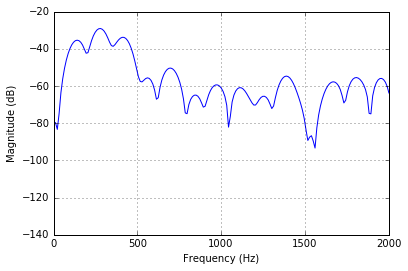

In [5]:
# DFT parameters
frame_size = 1024 # how many samples to include in our frame
fft_size = frame_size * 4 # we zero-pad the signal for visualization purposes

# Compute DFT of windowed frame
start_sample = 5 * sr
frame = audio[start_sample:start_sample + frame_size]
win = np.blackman(frame_size) / (np.blackman(frame_size).sum() / 2.)
xwin = frame * win
Xwin = librosa.spectrum.fft.fft(xwin, n=fft_size)

# Plot the DFT
fig = plt.figure()
plt.plot(np.arange(fft_size//2) * sr/float(fft_size), 20*np.log10(np.abs(Xwin[:fft_size//2])))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 2000)
# plt.ylim(-120,0)
plt.grid()
plt.show()

## From DFT to the STFT

The DFT gives us the spectrum for a single frame (small set of consecutive samples of the audio signal). The Short-Time Fourier Transform is basically the process of computing the DFT for the entire audio signal by slicing in into small, consecutive, potentially overlapping frames and computing the DFT for each frame. The STFT has 4 key parameters:
* The frame (window) size 
* The fft size (can be same as frame size or if we want zero padding it can be larger)
* The hop size
* The window function

### Frame size
The frame size defines the number of audio samples to include in a single frame. While the frame size is defined in terms of number of samples, it is more useful to think of the frame size in terms of duration in seconds or milliseconds. For example, given a sample rate ```sr = 44100```, a frame size of 46.44 ms (0.046 seconds) corresponds to ```np.round(0.04644 * sr) = 2048``` audio samples. It is customary to choose frame sizes (in samples) that are a power of 2 (256, 512, 1024, 2048, 4096, 8192, etc.): this is because some FFT implementations are optimized for this.

**What is the influence of the frame size?** The larger the frame size, the more samples we use to compute the spectrum (i.e. our DFT size is larger). The main advantage is that this increases the frequency resolution of the analysis, i.e. the peaks of the spectrum are "narrower" and it is easier to distinguish between peaks at close frequencies. However, a larger frame size comes at a cost: it decreases the temporal accuracy of the analysis. Since we are using more samples (i.e. a longer segment of the audio), we lose the ability to identify the precise time in which events (e.g. note onsets) happen. This is an inherent trade-off of the Fourier transform (sometimes likened, though unrelated, to the Heisenberg uncertainty principle): you can improve the frequency resolution (by using a larger frame size) or you can improve the temporal resolution (by using a smaller frame size), but you can't do both.

### FFT size
The size of the fft transform. It can be the same size as the frame size, or, if we want to zero-pad the signal to obtain a smoother (interpolated) representation of the spectrum, we can make it bigger (ideally still a power of 2). In the example below we will keep the fft size the same as the frame size.

### Hop size
The hop size defines the increment (in audio samples) from one frame to the next. That is, if the first sample of the current frame is sample X, the first sample of the next frame will be sample X + hopsize. For example, if our frame size is 2048, and our hop size is 1024, it means the first frame will span samples 0--2047, the second frame will span samples 1024--3071, the third frame will span samples 2048--4095, etc.

Choosing the right hop size will depend on your analysis. The smaller the hop size, the smaller the difference between the spectrum of one frame and the next will be (the STFT will be "smoother"). However, this comes at the cost of computing more frames, meaning longer execution time and larger data.

### Window function
As explained in the DFT notebook, the window function helps us reduce artifacts in the DFT. Depending on your application it is often the case that the specific choice of window function (Hann, Hammin, Blackman-Harris, etc.) is not critical as long as you use one of the standard functions (and *not* a rectangular window).

## Computing the STFT

Let's put all this together to compute the STFT of the audio signal:

In [6]:
# STFT parameters
frame_size = 1024 # how many samples to include in one frame
fft_size = frame_size # no zero padding
hop_size = 512 # how many samples to skip between one frame and the next
win = np.blackman(frame_size) / (np.blackman(frame_size).sum() / 2.) # the window function

# Compute the STFT:
# NOTE: this is NOT the most efficient way to compute the STFT in Python, 
# but it is useful for instructive purposes

start_sample = 0
stft = []

while start_sample + frame_size < len(audio):
    
    # Slice the next frame out of the audio signal
    frame = audio[start_sample:start_sample + frame_size]
    
    # Window the frame and compute the DFT
    xwin = frame * win
    Xwin = librosa.spectrum.fft.fft(xwin, n=fft_size)
    
    # Keep only the non-negative frequencies
    Xwin = Xwin[:fft_size//2 +1]
    
    # Add the DFT of th frame to the STFT
    stft.append(Xwin)
    
    # Advance the start_sample by the hop size:
    start_sample += hop_size

## Visualizing the STFT: The Spectrgoram

Now we can plot the STFT! The visualization of the STFT is called a **spectrogram**. The two terms are sometimes used interchangeably in the audio processing literature. Remember that we need to take the abs() to obtain the magnitude spectrum (since the DFT returns complex values) and that for visualization it is helpful to use a logarithmic scale:

In [7]:
stft2 = np.asarray(stft) # this will make life easier

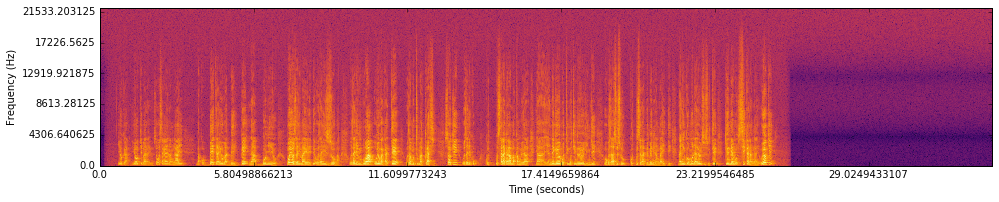

In [8]:
# Here we go. Note that it takes some effort to get the axis labels into the right units!
# Also note that we need to transpose the matrix so that it displays correctly using imshow()
fig, ax = plt.subplots(figsize=(16, 10))
plt.imshow(20*np.log10(np.abs(stft2.T)), interpolation='nearest', cmap='inferno', origin='lower' )
ax.set_xticklabels(ax.get_xticks() * hop_size / float(sr))
ax.set_yticklabels(ax.get_yticks() * sr / float(fft_size))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.show()

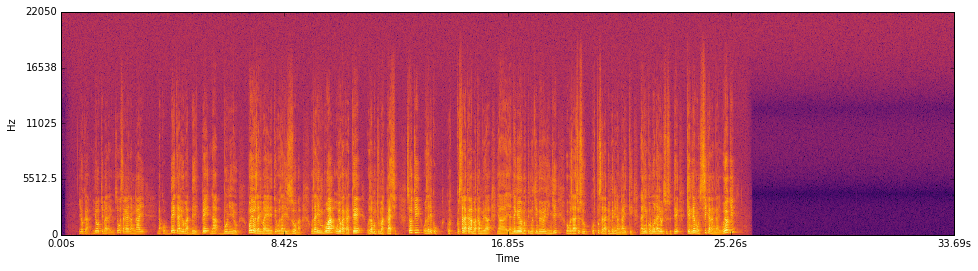

In [9]:
# Alternatively, we can use librosa to do all the hard plotting work for us!
fig = plt.figure(figsize=(16, 4))
librosa.display.specshow(20*np.log10(np.abs(stft2.T)), sr=sr, 
                         hop_length=hop_size, x_axis='time', y_axis='linear', cmap='inferno')
plt.show()

## STFT in practice

Now that we have a good understanding of the STFT, we can use librosa to compute it directly from the audio signal:

In [10]:
stft3 = librosa.stft(audio, n_fft=frame_size, hop_length=hop_size, window=np.hanning)

In [11]:
# Let's see the shape
stft3.shape

(513, 2905)

Note that the built-in librosa stft function only returns the non-negative part of the fft (513 bins in this case)! Let's plot it again (note that we no longer need to transpose the matrix):

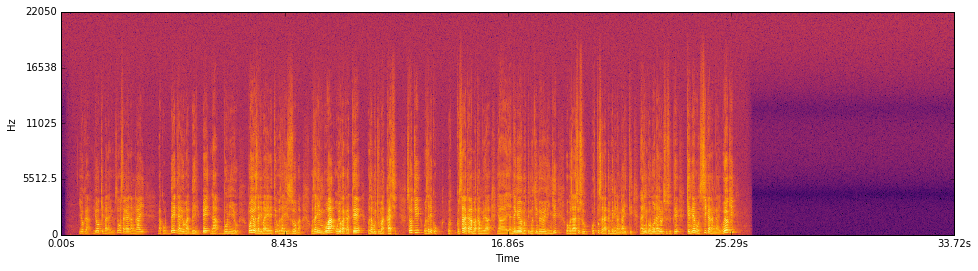

In [12]:
fig = plt.figure(figsize=(16, 4))
librosa.display.specshow(20*np.log10(np.abs(np.asarray(stft3))), sr=sr, 
                         hop_length=hop_size, x_axis='time', y_axis='linear', cmap='inferno')
plt.show()